In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.cluster.vq import kmeans, kmeans2, whiten, vq
import sklearn
from sklearn import metrics
from scipy.spatial.distance import cdist
import pickle
%matplotlib inline
sns.set_style('white', {'axes.grid' : False}) # Setting a default figure style for all plots

In [2]:
evo_travels = pd.read_csv('../../Python Scripts/travels_id_tratado.csv')

## Useful Functions

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate distance between the geo coordinates
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000

    return m

In [4]:
def plot_elbow(data, k, mark=4, title='Elbow for K-Means clustering', savefile=''):
    """
    Calculates the kmeans for k number of clusters and plot a figure
    to be used the elbow method.
    """

    # Normalizing
    X = whiten(data)

    K = range(1,k)

    print('Calculating Kmeans...')
    KM = [kmeans(X,k, iter=30) for k in K] # apply kmeans 1 to k
    centroids = [cent for (cent,var) in KM]   # cluster centroids

    print('Calculating distance...')
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]  

    print('All Done!')
    kIdx = mark - 1

    # plot elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    #plt.xlabel('Number of clusters')
    plt.xlabel('Número de clusters')
    #plt.ylabel('Average within-cluster sum of squares')
    plt.ylabel('Soma média dos quadrados intra-cluster')
    tt = plt.title(title)  

    if savefile != '':
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

In [5]:
def hour_stats(data, hour):
  
    hour_data = data[data['hour'] == hour]['percentage']

    stats = {}

    stats['mean'] = hour_data.mean()
    stats['median'] = hour_data.median()
    stats['q1'] = hour_data.quantile(.25)
    stats['q3'] = hour_data.quantile(.75)
    stats['q4'] = hour_data.quantile(1)
    stats['std'] = hour_data.std()

    return stats

In [6]:
# Colors for the clusters
LABEL_COLOR_MAP = {0: '#920000',
                   1: '#004949',
                   2: '#ff6db6',
                   3: '#490092',
                   4: '#dbd100',
                   5: '#000000',
                   6: '#b66dff',
                   7: '#ffff6d'}

Raw data and divisions of North Vancouver and New Westminster

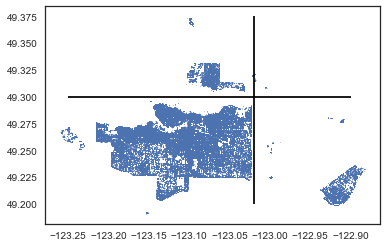

In [5]:
plt.hlines(49.3,-123.25,-122.9)
plt.vlines(-123.02,49.2,49.375)

plt.scatter(evo_travels['Start_lon'], evo_travels['Start_lat'], s=0.1)
plt.show()

## Data manipulation

In [7]:
evo_travels['Start_time'] = pd.to_datetime(evo_travels['Start_time'])
evo_travels['End_time'] = pd.to_datetime(evo_travels['End_time'])

# Adding a distance(m) column
evo_travels['distance'] = evo_travels.apply(lambda x: haversine(x.Start_lon,x.Start_lat,
                                                                x.End_lon,x.End_lat), axis=1)

# Columns of hour and weekday of each occurrence
evo_travels['hour'] = evo_travels['Start_time'].dt.hour
evo_travels['weekday'] = evo_travels['Start_time'].dt.weekday # 0 = Monday, 6 = Sunday

# Binary columns of daily periods
evo_travels['dawn'] = (evo_travels['hour'] < 6).astype('int')
evo_travels['morning'] = ((evo_travels['hour'] >= 6) & (evo_travels['hour'] < 12)).astype('int')
evo_travels['afternoon'] = ((evo_travels['hour'] >= 12) & (evo_travels['hour'] < 18)).astype('int')
evo_travels['night'] = ((evo_travels['hour'] >= 18) & (evo_travels['hour'] <= 23)).astype('int')

# Removing New Westminster
evo_travels = evo_travels[(evo_travels['Start_lon'] < -123.02)]
evo_travels = evo_travels[(evo_travels['End_lon'] < -123.02)]

In [8]:
evo_travels.head()

,Id,Start_time,Start_lat,Start_lon,Fuel_start,End_time,End_lat,End_lon,Fuel_end,duration,distance,hour,weekday,dawn,morning,afternoon,night
1,JTDKDTB32G1589000,2018-03-01 18:09:30.383898,49.314045,-123.083481,84,2018-03-01 18:33:40.410390,49.314045,-123.083481,84,24.167108,0.000000e+00,18,3,0,0,0,1
2,JTDKDTB32G1589000,2018-03-01 18:36:09.073847,49.314045,-123.083481,84,2018-03-01 20:24:36.451198,49.315067,-123.083481,83,108.456289,1.136032e+02,18,3,0,0,0,1
3,JTDKDTB32G1589000,2018-03-01 20:39:21.714875,49.315067,-123.083481,83,2018-03-01 21:09:48.876096,49.315067,-123.083481,83,30.452687,7.068790e-10,20,3,0,0,0,1
4,JTDKDTB32G1589000,2018-03-01 21:12:05.647857,49.315067,-123.083481,83,2018-03-01 21:15:26.307443,49.315067,-123.083481,83,3.344326,7.068790e-10,21,3,0,0,0,1
5,JTDKDTB32G1589000,2018-03-01 21:18:46.154800,49.315067,-123.083481,83,2018-03-01 21:33:18.854778,49.327805,-123.081482,83,14.545000,1.422821e+03,21,3,0,0,0,1


## Finding the optimal number of clusters for weekdays and weekends

In [9]:
labels = ['Start_lat', 'Start_lon', 'Fuel_start', 'End_lat',
          'End_lon', 'Fuel_end', 'duration', 'distance',
          'dawn', 'morning', 'afternoon', 'night']

weekdays = evo_travels[evo_travels['weekday'] < 5][labels]
weekends = evo_travels[evo_travels['weekday'] >= 5][labels]

Weekdays:

Calculating Kmeans...
Calculating distance...
All Done!


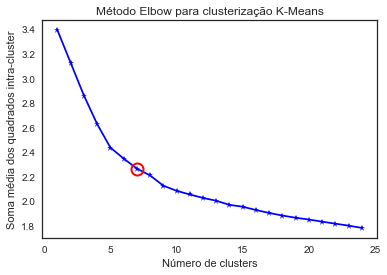

In [30]:
plot_elbow(weekdays, 25, mark=7, title='Método Elbow para clusterização K-Means', 
           savefile='../../clusters_data/Images/weekdays_elbow.pdf')

For weekdays will be choose 7 clusters

Weekends:

Calculating Kmeans...
Calculating distance...
All Done!


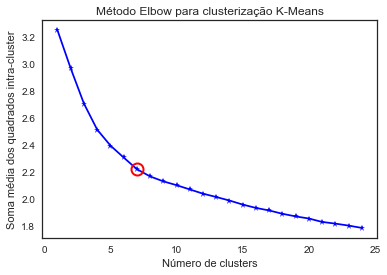

In [31]:
plot_elbow(weekends, 25, mark=7, title='Método Elbow para clusterização K-Means', 
           savefile='../../clusters_data/Images/weekends_elbow.pdf')

For weekends will be choose 7 clusters

## Plotting the clusterization

Weekdays:

In [10]:
x, y = kmeans2(whiten(weekdays), 7, iter = 30)

In [11]:
# Column with groups
weekdays['cluster'] = y

In [12]:
# Optional: Saving externaly
pickle.dump(weekdays, open( "../../clusters_data/weekdays_cluster.p", "wb" ))

In [10]:
weekdays = pd.read_pickle("../../clusters_data/weekdays_cluster.p")

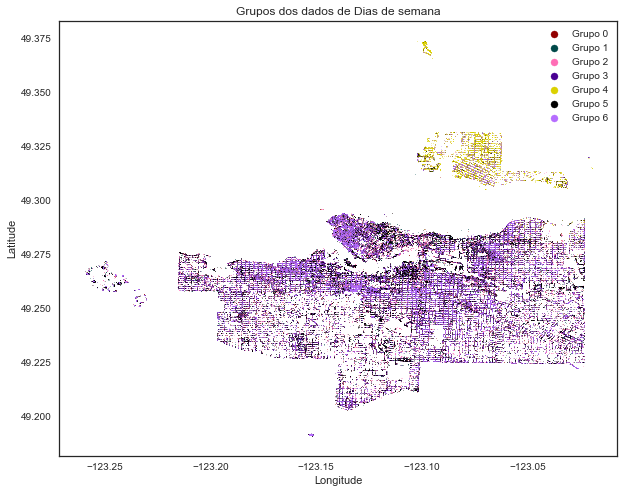

In [13]:
plt.figure(figsize=(10,8))

groups = weekdays['cluster'].unique()
groups.sort()

for g in groups:
    group_data = weekdays[weekdays['cluster'] == g]
    plt.scatter(group_data['Start_lon'], group_data['Start_lat'], c=LABEL_COLOR_MAP[g], s=0.1, label='Grupo '+str(g))

#plt.title('Grouping Weekends data')
plt.title('Grupos dos dados de Dias de semana')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Changing the size of legend point
legend = plt.legend()
for g in groups:
    legend.legendHandles[g]._sizes = [50]

plt.savefig('../../clusters_data/Images/weekdays_clusters.pdf', bbox_inches='tight')

plt.show()

Weekends:

In [14]:
x, y = kmeans2(whiten(weekends), 7, iter = 30, minit='points')

In [15]:
# Column with groups
weekends['cluster'] = y

In [16]:
# Optional: Saving externaly
pickle.dump(weekends, open( "../../clusters_data/weekends_cluster.p", "wb" ))

In [ ]:
weekends = pd.read_pickle("../../clusters_data/weekends_cluster.p")

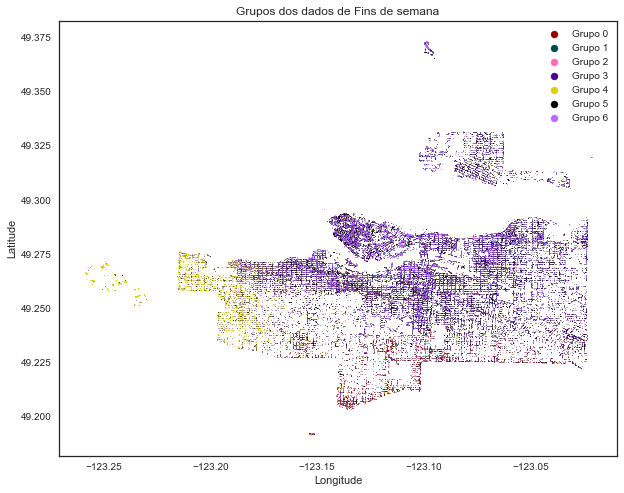

In [17]:
plt.figure(figsize=(10,8))

groups = weekends['cluster'].unique()
groups.sort()

for g in groups:
    group_data = weekends[weekends['cluster'] == g]
    plt.scatter(group_data['Start_lon'], group_data['Start_lat'], c=LABEL_COLOR_MAP[g], s=0.1, label='Grupo '+str(g))

plt.title('Grupos dos dados de Fins de semana')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Changing the size of legend point
legend = plt.legend()
for g in groups:
    legend.legendHandles[g]._sizes = [50]
    
plt.savefig('../../clusters_data/Images/weekends_clusters.pdf', bbox_inches='tight')

plt.show()

## Creating a data structure of regions that have more concetration of a cluster:

In [18]:
# Creating points of Vancouver region
latitudes = []
longitudes = []
for lat in np.arange(49.18,49.38,0.003):
    for lon in np.arange(-123.26,-123.02,0.003):
        latitudes.append(lat)
        longitudes.append(lon)
        
points = pd.DataFrame({'lon':longitudes, 'lat':latitudes})

Visualizing this points:

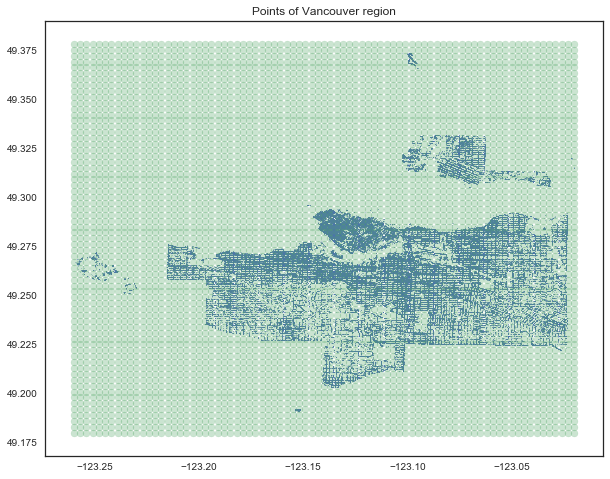

In [39]:
plt.figure(figsize=(10,8))
plt.scatter(evo_travels['Start_lon'], evo_travels['Start_lat'], s=0.1)
plt.scatter(points['lon'], points['lat'], alpha=0.3)
plt.title('Points of Vancouver region')

plt.show()

In [19]:
def geojson_builder(down_left,up_right,group):
    """
    Build a rectangle geojson from two points.
    """
    p1 = [str(down_left[0]),str(down_left[1])]
    p2 = [str(up_right[0]),str(down_left[1])]
    p3 = [str(up_right[0]),str(up_right[1])]
    p4 = [str(down_left[0]),str(up_right[1])]
    
    geojson = {"type": "FeatureCollection",
              "features": [
                {"type": "Feature",
                    "properties":{
                        "group": str(group)
                    },
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": [[p1,p2,p3,p4,p1]] }}]}

    return geojson

In [20]:
def build_regions(data, points):
    """
    Create a list of geojsons that represent the group more 
    significant in the region.
    """
  
    # Creating matrix of the region coordinates
    # matrix dimensions based in points
    lat = points['lat'].unique()
    step = round(abs(lat[0]-lat[1]),5)
    diff = abs(lat.max() - lat.min())

    len_y = int(diff/step)+1

    lon = points['lon'].unique()
    step = round(abs(lon[0]-lon[1]),5)
    diff = abs(lon.max() - lon.min())

    len_x = int(diff/step)+1
    
    
    matrix = []

    # filling the matrix with the points coordinates
    c = 0
    for y in range(len_y):
        line = []
        for x in range(len_x):
            line.append((points['lon'].iloc[c], points['lat'].iloc[c]))
            c+=1
        matrix.append(line)

    geojsons = []
    
    # Column options for travels and idle datasets
    lat_column = 'lat'
    lon_column = 'lon'
    if not data.columns.isin([lat_column,lon_column]).any():
        lat_column = 'Start_lat'
        lon_column = 'Start_lon'
    
    for lin in range(len(matrix)-1):
        for col in range(len(matrix[0])-1):

            # Selecting all points inside a square of matrix coordinates
            down_left = matrix[lin][col]
            up_right = matrix[lin+1][col+1]
            
            lon_condition = (data[lon_column] >= down_left[0]) & (data[lon_column] <= up_right[0])
            lat_condition = (data[lat_column] >= down_left[1]) & (data[lat_column] <= up_right[1])

            travels = data.loc[lon_condition & lat_condition]

            if len(travels) != 0:
                # Build a geojson of the group more significant in the square
                group = travels['cluster'].value_counts().index[0]
                geojsons.append(geojson_builder(down_left,up_right,group))
                
                # Changing group of the other travels
                data.loc[lon_condition & lat_condition, 'cluster'] = [group]*len(travels)

            
    return geojsons

In [21]:
def plot_regions(geo_jsons, savefile=''):
    """
    Plot a map of the regions.
    """
    
    plt.figure(figsize=(10,8))
    fig, ax = plt.subplots()
    
    group_set = set()
    
    for json in geo_jsons:
        coords = json['features'][0]['geometry']['coordinates'][0]
        group = int(json['features'][0]['properties']['group'])
        
        group_set.add(group) # Store the group of the plots for legend
        
        x = [i for i,j in coords]
        y = [j for i,j in coords]
        
        plt.fill(x,y, color=LABEL_COLOR_MAP[group])
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Legend for each group
    legend_patches = []
    for g in group_set:
        legend_patches.append(mpatches.Patch(color=LABEL_COLOR_MAP[g], label='Região '+str(g)))
    
    plt.legend(handles=legend_patches)
    plt.tight_layout()
    
    if savefile != '':
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

In [22]:
weekdays_geojsons = build_regions(weekdays, points)
weekends_geojsons = build_regions(weekends, points)

# Optional: Saving externaly
pickle.dump(weekdays_geojsons, open( "../../clusters_data/weekdays_geojsons.p", "wb" ))
pickle.dump(weekends_geojsons, open( "../../clusters_data/weekends_geojsons.p", "wb" ))

Weekdays regions:

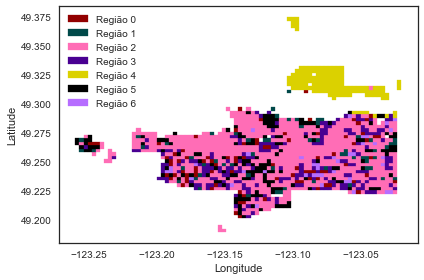

In [23]:
plot_regions(weekdays_geojsons, savefile='../../clusters_data/Images/weekdays_regions.pdf')

Weekends regions:

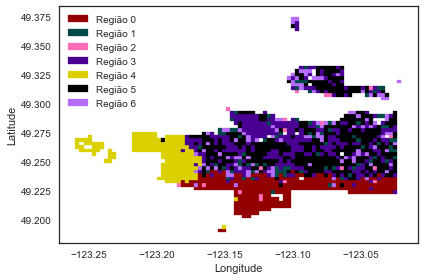

In [24]:
plot_regions(weekends_geojsons, savefile='../../clusters_data/Images/weekends_regions.pdf')

In [26]:
# Optional: Saving externaly
pickle.dump(weekdays, open( "../../clusters_data/weekdays_regions.p", "wb" ))
pickle.dump(weekends, open( "../../clusters_data/weekends_regions.p", "wb" ))

## Weekdays and Weekends data status

In [25]:
def count_busy(df, period):
    """
    Count business activity of each occurence of the dataframe in the 
    period.
    """

    busy = []
    idle = []

    # Vehicle id list in order to make a percentage of busy cars in each minute
    car_ids = df.Id.unique()
    n_cars = len(car_ids)

    # Going through each collected minute
    for dt in period:
        # Counting the number of travels that this minute is included
        in_travel = len(df[(df['Start_time'] <= dt) & (dt < df['End_time'])].Id.unique())
        percentage = (in_travel/n_cars) * 100

        busy.append([dt, in_travel, percentage])

    return pd.DataFrame(busy, columns=['capture_time','count','percentage'])

In [27]:
# Bring back the start time, end time and Id column
merge_labels = labels + ['Start_time', 'End_time', 'Id']

weekdays = pd.merge(weekdays, evo_travels[merge_labels], on=labels)
weekends = pd.merge(weekends, evo_travels[merge_labels], on=labels)

In [ ]:
busy_weekdays = count_busy(weekdays,weekdays.Start_time.unique())
busy_weekends = count_busy(weekends,weekends.Start_time.unique())

busy_weekdays['hour'] = busy_weekdays.capture_time.dt.hour
busy_weekends['hour'] = busy_weekends.capture_time.dt.hour

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)

busy_weekdays.boxplot(column='percentage',by='hour',ax=ax1)
ax1.set_title('Weekdays')

busy_weekends.boxplot(column='percentage',by='hour',ax=ax2)
ax2.set_title('Weekends')


fig.tight_layout()
plt.show()

## Data status of each group

In [28]:
def region_size(data_geojsons):
    """
    Calculates the percentage of the covered area of a region in a relation to the number of regions.
    """
    
    total_of_regions = len(data_geojsons) # total size of regions
    
    percentages = {} # dict to store the area of each region
    
    for region in data_geojsons:
        group = int(region['features'][0]['properties']['group'])
        
        if group in percentages.keys():
            percentages[group] += 1
        else:
            percentages[group] = 1
        
    percentages = {k: 100 * v / total_of_regions for k, v in percentages.items()}
    
    return percentages

In [37]:
def plot_boxplots(data, nrows, ncols, figsize, filepath, ylim=50, norm_data=None):
    
    groups = data['cluster'].unique()
    groups.sort()
    
    # Calculating the size of the region to normalize the results
    percentages = {}
    if norm_data != None:
        percentages = region_size(norm_data)
    
    busy_list = []
    for g in groups:
        travels_group = data[data['cluster'] == g]

        busy_group = count_busy(travels_group,travels_group.Start_time.unique())
        busy_group['hour'] = busy_group.capture_time.dt.hour
        
        # Normalizing the data
        if norm_data != None:
            busy_group['percentage'] = busy_group['percentage']*(percentages[g]/100)

        busy_list.append(busy_group)
    
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.5, top=0.7)
    c = 0
    l = 0

    for g, busy_group in zip(groups, busy_list):
        # Ploting in matrix format
        busy_group.boxplot(column='percentage',by='hour',ax=axarr[l, c])

        plt.ylim(0,1)

        axarr[l, c].set_title('Group '+str(g))
        axarr[l, c].set_ylim(0,ylim)
        axarr[l, c].grid(False)
        
        # Plotting each box plot alone and saving
        fig_temp, ax_temp = plt.subplots()
        busy_group.boxplot(column='percentage',by='hour',ax=ax_temp)
        ax_temp.grid(False)
        ax_temp.set_title('')
        ax_temp.set_xlabel('hora')
        ax_temp.set_ylabel('porcentagem')
        ax_temp.set_ylim(0, 100)
        fig_temp.savefig(filepath+'group_'+str(g)+'.pdf', bbox_inches='tight')
        plt.close(fig_temp) # Close this temporary plot

        c+=1
        if (c >= ncols): # aux variables to plot in matrix format
            c = 0
            l += 1

    plt.tight_layout()
    
    plt.savefig(filepath+'boxplot_matrix.pdf', bbox_inches='tight')
    
    plt.show()

Weekdays:

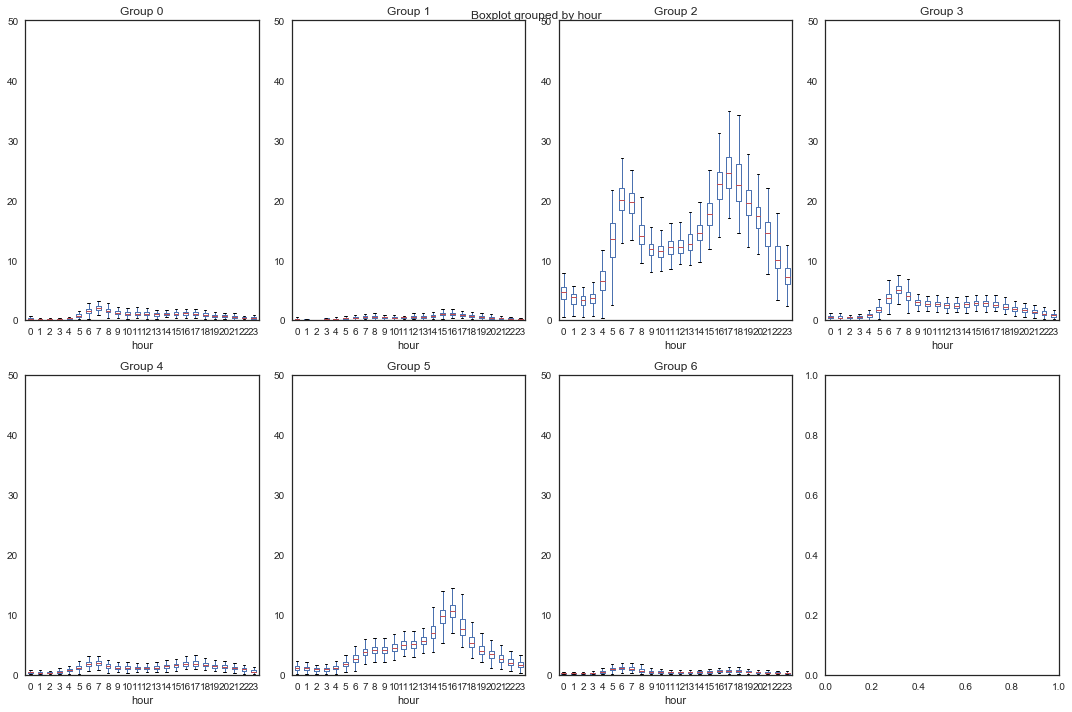

In [38]:
plot_boxplots(weekdays, nrows=2, ncols=4, figsize=(15,10), ylim=50, filepath='../../clusters_data/Images/weekdays_boxplots/')

Weekends:

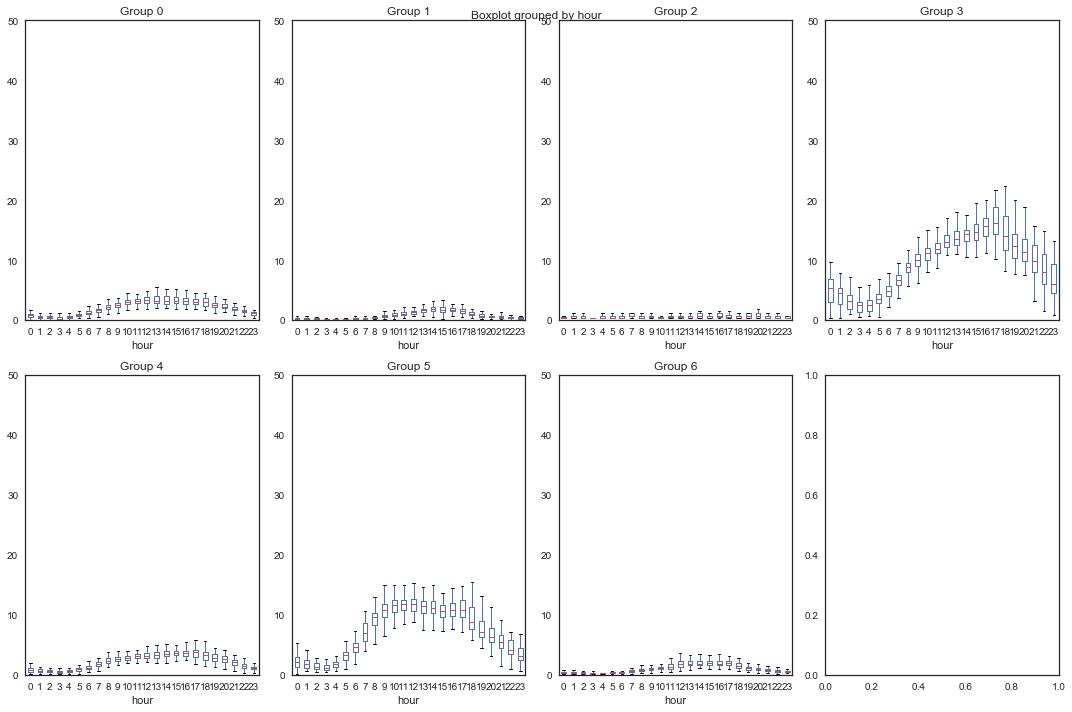

In [39]:
plot_boxplots(weekends, nrows=2, ncols=4, figsize=(15,10), ylim=50, filepath='../../clusters_data/Images/weekends_boxplots/')

### Normalizing data in the relation of size of each region

Weekdays:

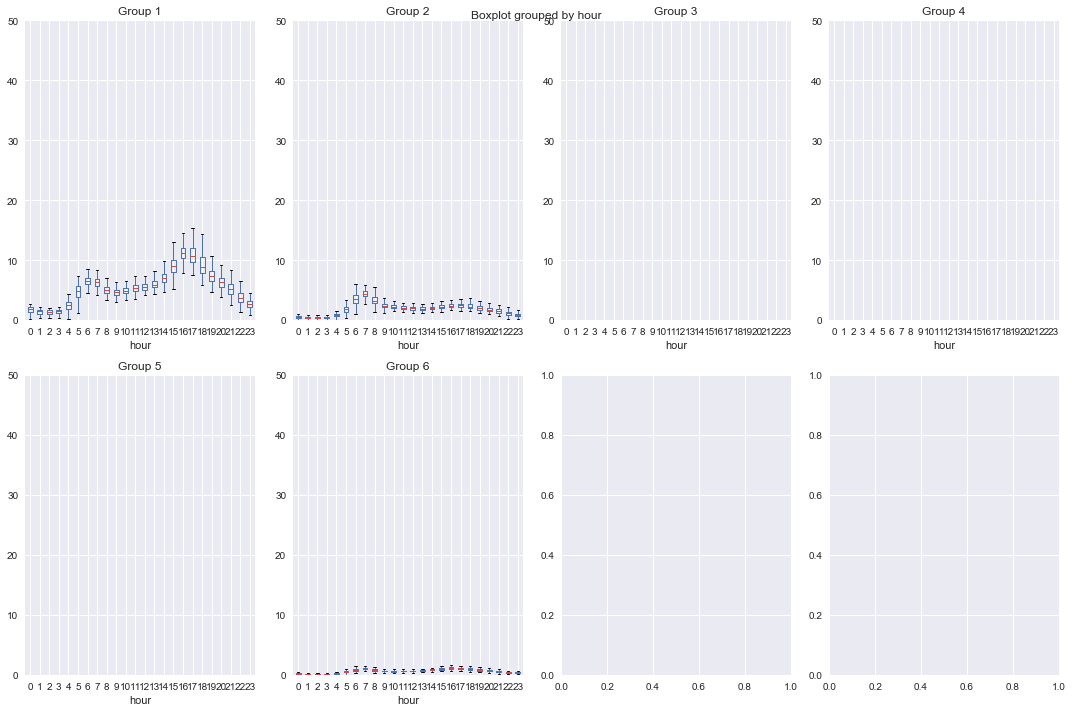

In [75]:
plot_boxplots(weekdays, nrows=2, ncols=4, figsize=(15,10), ylim=50, norm_data=weekdays_geojsons)

Weekends:

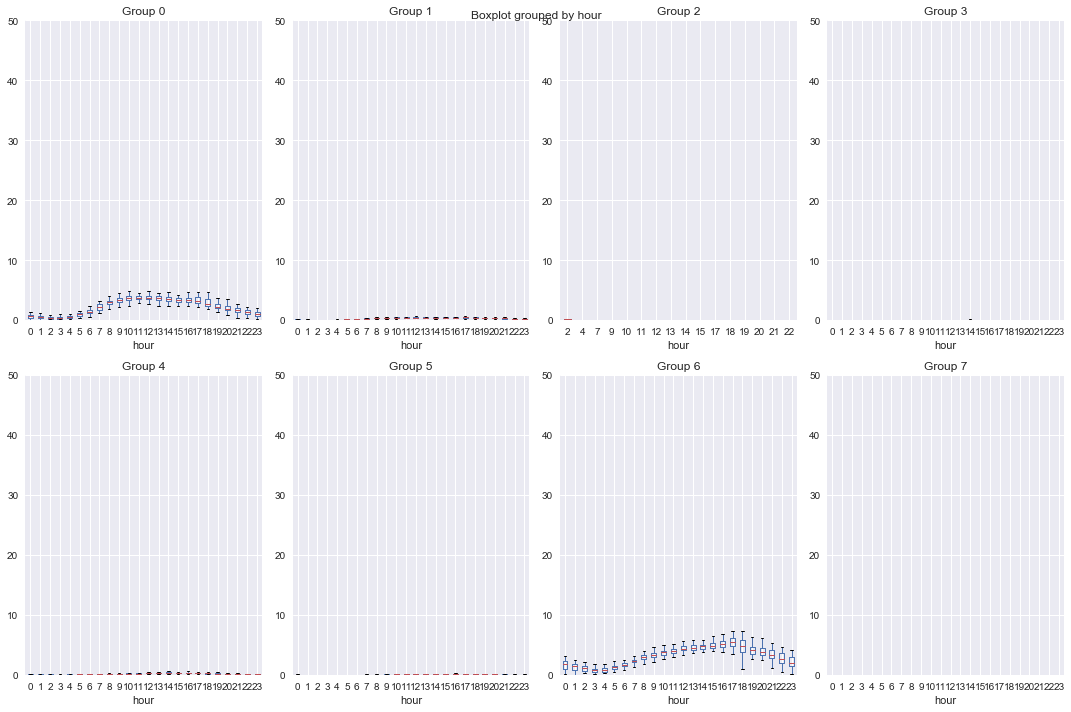

In [79]:
plot_boxplots(weekends, nrows=2, ncols=4, figsize=(15,10), ylim=50, norm_data=weekends_geojsons)

## Analysing duration, distance and fuel use of the groups

### Distance:

In [32]:
def cdf(df, column):
    """
    Calcula valores de todas as coordenadas (x,y) para uma CDF.
    
    Parameters
    -----------
    df : float list, pandas.DataFrame
        Lista de valores de durações para ser feita a CDF.
    
    Returns
    ---------
    x, y: float list
        Lista de todas as coordenadas da CDF.
        
    """
    
    df = df.sort_values(by=column)
    values = df[column]
    
    x = []
    y = []

    total = float(len(values))
    cnt = 0
    last = values.iloc[0]
    for data in values:
        if data != last:
            x.append(last)
            y.append(cnt/total)
            
            cnt += 1
            last = data
        else:
            cnt += 1
    x.append(last)
    y.append(cnt/total)
    
    return x, y

In [60]:
def plot_cdf(data, column, xscale='linear', xlabel='', ylabel='', title='',savefile=''):
    groups = data['cluster'].unique()
    groups.sort()
    
    for g in groups:

        group_data = data[data['cluster'] == g]

        x, y = cdf(group_data.copy(), column)
        plt.plot(x,y, color=LABEL_COLOR_MAP[g], label='Região '+str(g))

    plt.ylim(0,1)
    plt.xscale(xscale)
    plt.xlim(left=0)
    
    plt.legend(loc=4, borderaxespad=0.2, frameon=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    
    if savefile != '':
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

In [61]:
def plot_cdf_matrix(data, column, nrows, ncols, figsize, xscale='linear', save_file=None):
    
    groups = data['cluster'].unique()
    groups.sort()
    
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.5, top=0.7)
    c = 0
    l = 0

    for g in groups:

        group_data = data[data['cluster'] == g]

        x, y = cdf(group_data.copy(), column)
        axarr[l, c].plot(x,y, color=LABEL_COLOR_MAP[g])

        plt.ylim(0,1)

        axarr[l, c].set_title('Região '+str(g))
        if (column == 'distance'):
            axarr[l, c].set_xlim(0,20000)
        axarr[l, c].set_ylim(0,1)
        axarr[l, c].set_xscale(xscale)

        c+=1
        if (c >= ncols): # aux variables to plot in matrix format
            c = 0
            l += 1

    plt.tight_layout()
    
    plt.savefig(save_file, bbox_inches='tight')
    plt.show()

Weekdays:

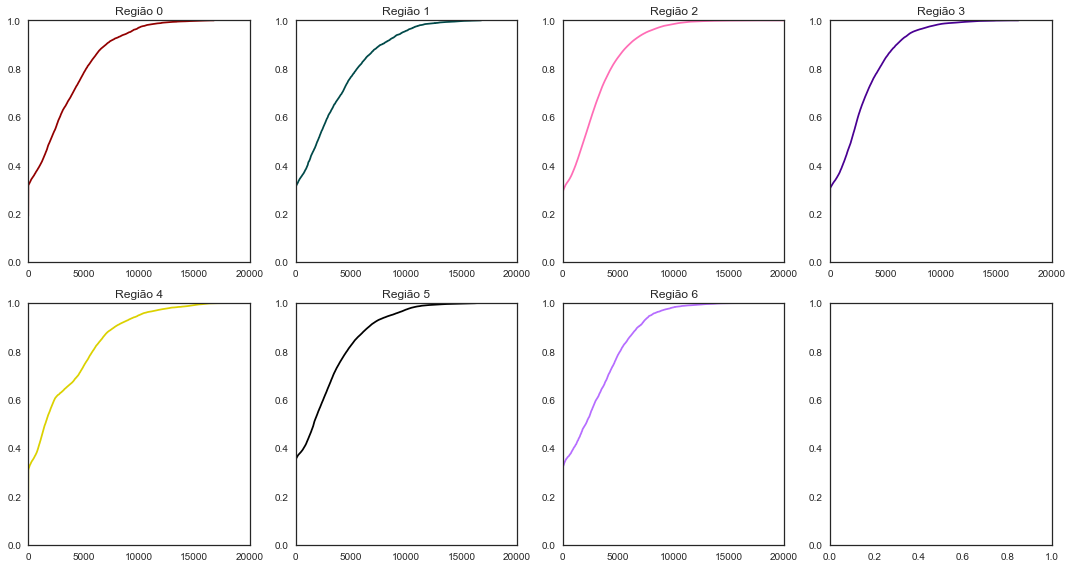

In [62]:
plot_cdf_matrix(weekdays, 'distance', 2, 4, (15,8))

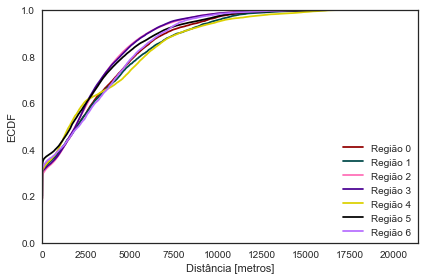

In [66]:
plot_cdf(weekdays, column='distance', xlabel='Distância [metros]', ylabel='ECDF', 
         savefile='../../clusters_data/Images/weekdays_distance.pdf')

Weekends:

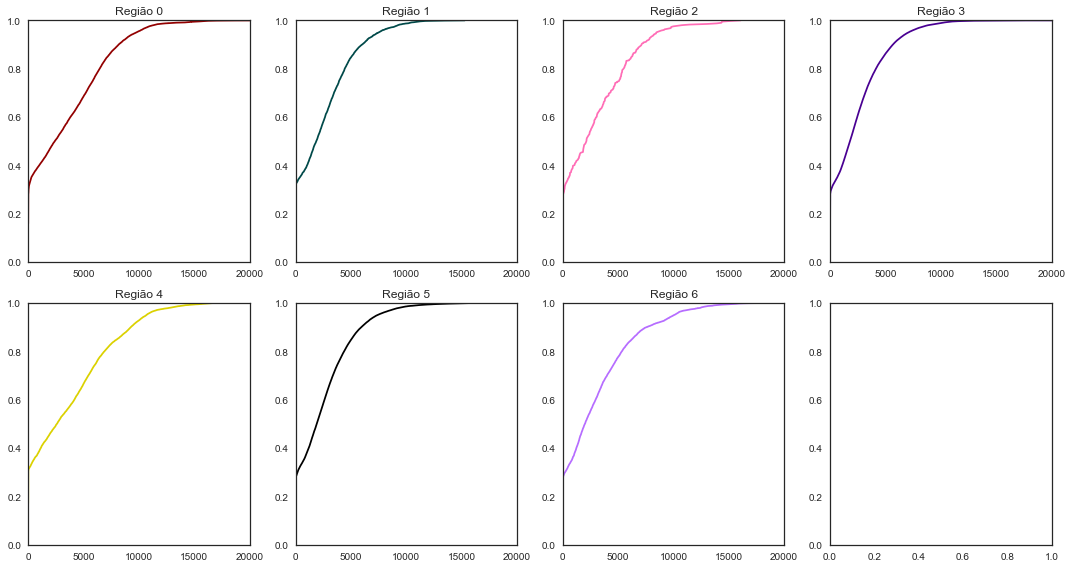

In [67]:
plot_cdf_matrix(weekends, 'distance', 2, 4, (15,8))

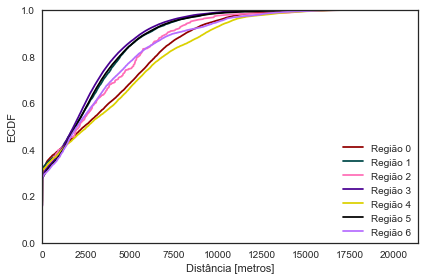

In [71]:
plot_cdf(weekends, column='distance', xlabel='Distância [metros]', ylabel='ECDF', 
         savefile='../../clusters_data/Images/weekends_distance.pdf')

### Duration:

Weekdays:

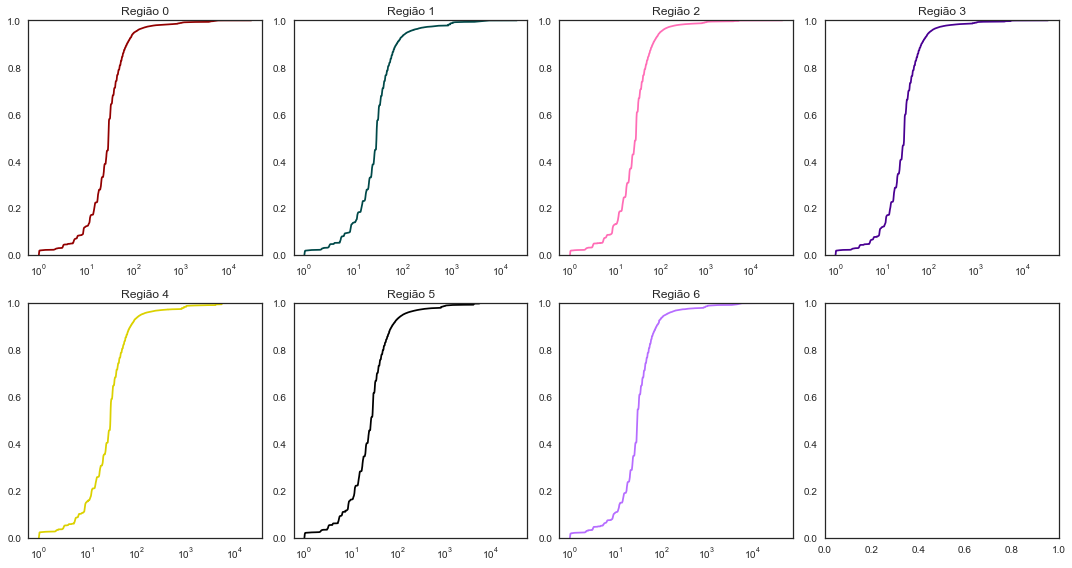

In [72]:
plot_cdf_matrix(weekdays, 'duration', 2, 4, (15,8), xscale='log')

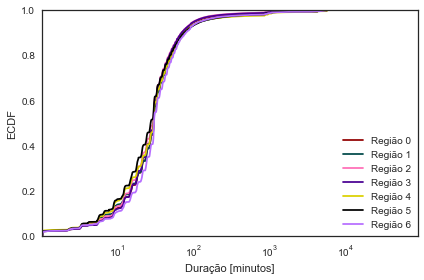

In [73]:
plot_cdf(weekdays, column='duration', xlabel='Duração [minutos]', ylabel='ECDF', xscale='log',
         savefile='../../clusters_data/Images/weekdays_duration.pdf')

Weekends:

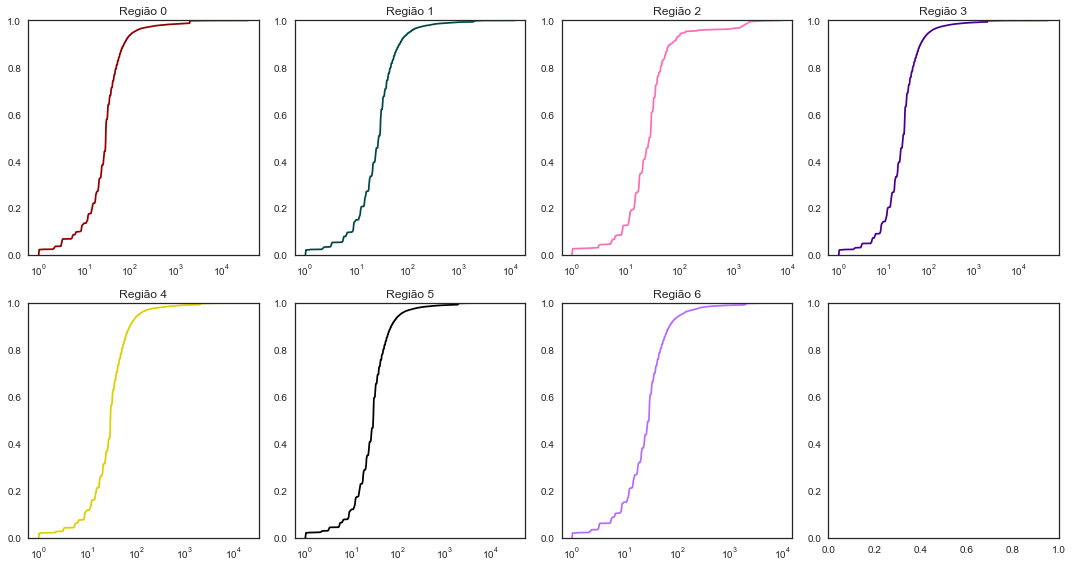

In [74]:
plot_cdf_matrix(weekends, 'duration', 2, 4, (15,8), xscale='log')

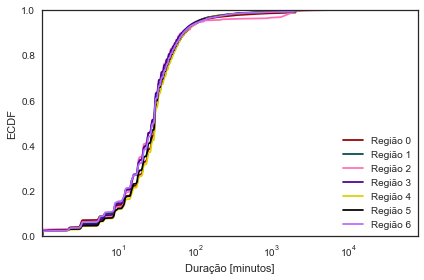

In [75]:
plot_cdf(weekends, column='duration', xlabel='Duração [minutos]', ylabel='ECDF', xscale='log',
         savefile='../../clusters_data/Images/weekends_duration.pdf')

### Fuel use:

Weekdays:

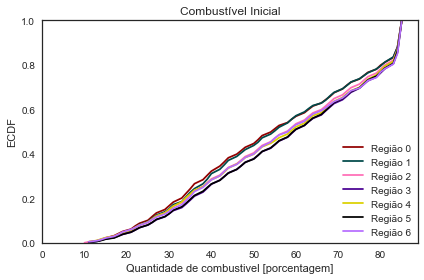

In [77]:
plot_cdf(weekdays, column='Fuel_start', title='Combustível Inicial', xlabel='Quantidade de combustivel [porcentagem]', 
         ylabel='ECDF', savefile='../../clusters_data/Images/weekdays_start_fuel.pdf')

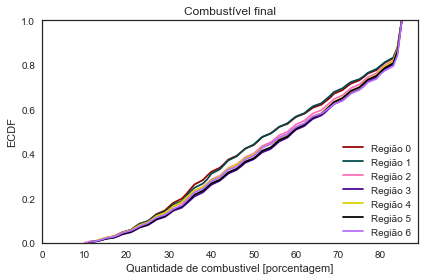

In [78]:
plot_cdf(weekdays, column='Fuel_end', title='Combustível final', xlabel='Quantidade de combustivel [porcentagem]', 
         ylabel='ECDF', savefile='../../clusters_data/Images/weekdays_end_fuel.pdf')

Weekends:

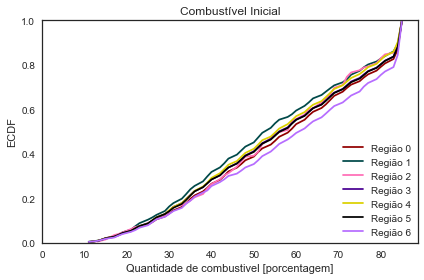

In [79]:
plot_cdf(weekends, column='Fuel_start', title='Combustível Inicial', xlabel='Quantidade de combustivel [porcentagem]', 
         ylabel='ECDF', savefile='../../clusters_data/Images/weekends_start_fuel.pdf')

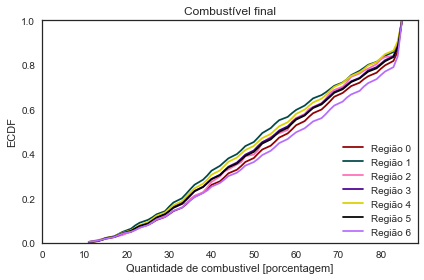

In [81]:
plot_cdf(weekends, column='Fuel_end', title='Combustível final', xlabel='Quantidade de combustivel [porcentagem]', 
         ylabel='ECDF', savefile='../../clusters_data/Images/weekends_end_fuel.pdf')

## Analysis of Idle period of each region

### Data manipulation

In [82]:
def idle_period(data):
    
    # Creating a parked duration dataframe
    parked_list = []
    car_ids = data.Id.unique()

    for id in car_ids:
        # Selecting all the data from each car
        car = data[data['Id'] == id]
        car = car.sort_values(by='Start_time')

        for i in range(1, len(car)):
            duration = car['Start_time'].iloc[i] - car['End_time'].iloc[i-1] # duration of the idle period
            duration = duration.total_seconds()/60
            
            region = car['cluster'].iloc[i-1] # region where the idle started
            hour = car['End_time'].iloc[i-1].hour # hour when start the period
            
            parked_list.append([id, car['End_time'].iloc[i-1], car['Start_time'].iloc[i],
                                car['Start_lon'].iloc[i], car['Start_lat'].iloc[i], duration, hour, region])

    idle = pd.DataFrame(parked_list, columns=['Id', 'Start_time', 'End_time', 'lon', 'lat', 'duration', 'hour', 'cluster'])
    
    return idle

In [83]:
weekdays_idle = idle_period(weekdays)
weekends_idle = idle_period(weekends)

In [84]:
# Binary columns of daily periods
weekdays_idle['dawn'] = (weekdays_idle['hour'] < 6).astype('int')
weekdays_idle['morning'] = ((weekdays_idle['hour'] >= 6) & (weekdays_idle['hour'] < 12)).astype('int')
weekdays_idle['afternoon'] = ((weekdays_idle['hour'] >= 12) & (weekdays_idle['hour'] < 18)).astype('int')
weekdays_idle['night'] = ((weekdays_idle['hour'] >= 18) & (weekdays_idle['hour'] <= 23)).astype('int')

weekends_idle['dawn'] = (weekends_idle['hour'] < 6).astype('int')
weekends_idle['morning'] = ((weekends_idle['hour'] >= 6) & (weekends_idle['hour'] < 12)).astype('int')
weekends_idle['afternoon'] = ((weekends_idle['hour'] >= 12) & (weekends_idle['hour'] < 18)).astype('int')
weekends_idle['night'] = ((weekends_idle['hour'] >= 18) & (weekends_idle['hour'] <= 23)).astype('int')

In [85]:
weekdays_idle.head()

,Id,Start_time,End_time,lon,lat,duration,hour,cluster,dawn,morning,afternoon,night
0,JTDKDTB32G1589000,2018-03-01 18:33:40.410390,2018-03-01 18:36:09.073847,-123.083481,49.314045,2.477724,18,4,0,0,0,1
1,JTDKDTB32G1589000,2018-03-01 20:24:36.451198,2018-03-01 20:39:21.714875,-123.083481,49.315067,14.754395,20,4,0,0,0,1
2,JTDKDTB32G1589000,2018-03-01 21:09:48.876096,2018-03-01 21:12:05.647857,-123.083481,49.315067,2.279529,21,4,0,0,0,1
3,JTDKDTB32G1589000,2018-03-01 21:15:26.307443,2018-03-01 21:18:46.154800,-123.083481,49.315067,3.330789,21,4,0,0,0,1
4,JTDKDTB32G1589000,2018-03-01 21:33:18.854778,2018-03-02 04:36:32.122512,-123.081482,49.327805,423.221129,21,4,0,0,0,1


In [86]:
weekends_idle.head()

,Id,Start_time,End_time,lon,lat,duration,hour,cluster,dawn,morning,afternoon,night
0,JTDKDTB32G1589000,2018-03-03 10:06:33.196156,2018-03-03 10:08:48.164930,-123.172173,49.262540,2.249480,10,0,0,1,0,0
1,JTDKDTB32G1589000,2018-03-03 10:29:48.090994,2018-03-03 10:33:05.016326,-123.118332,49.279427,3.282089,10,3,0,1,0,0
2,JTDKDTB32G1589000,2018-03-03 10:57:39.437581,2018-03-03 10:59:58.089603,-123.184311,49.266907,2.310867,10,3,0,1,0,0
3,JTDKDTB32G1589000,2018-03-03 11:36:37.627787,2018-03-03 11:42:12.038619,-123.106148,49.262096,5.573514,11,4,0,1,0,0
4,JTDKDTB32G1589000,2018-03-03 12:08:56.053829,2018-03-03 12:21:03.931309,-123.097519,49.284424,12.131291,12,5,0,0,1,0


### Data status of each group

Weekdays:

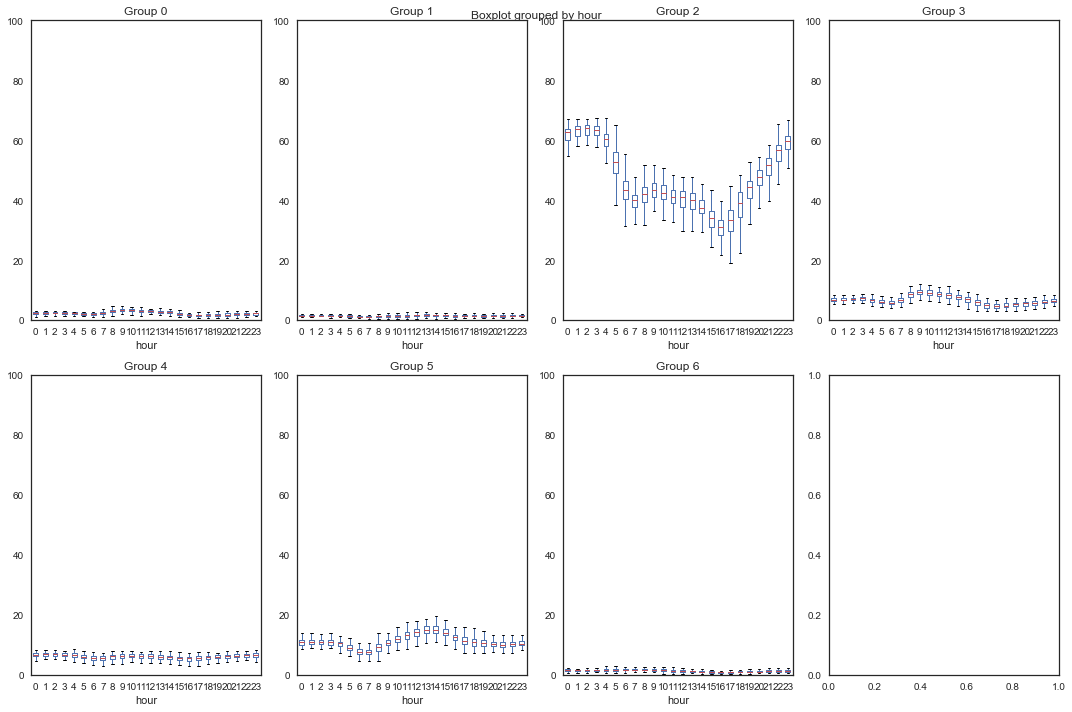

In [87]:
plot_boxplots(weekdays_idle, nrows=2, ncols=4, figsize=(15,10), ylim=100, 
              filepath='../../clusters_data/Images/weekdays_boxplots_idle/')

Weekends:

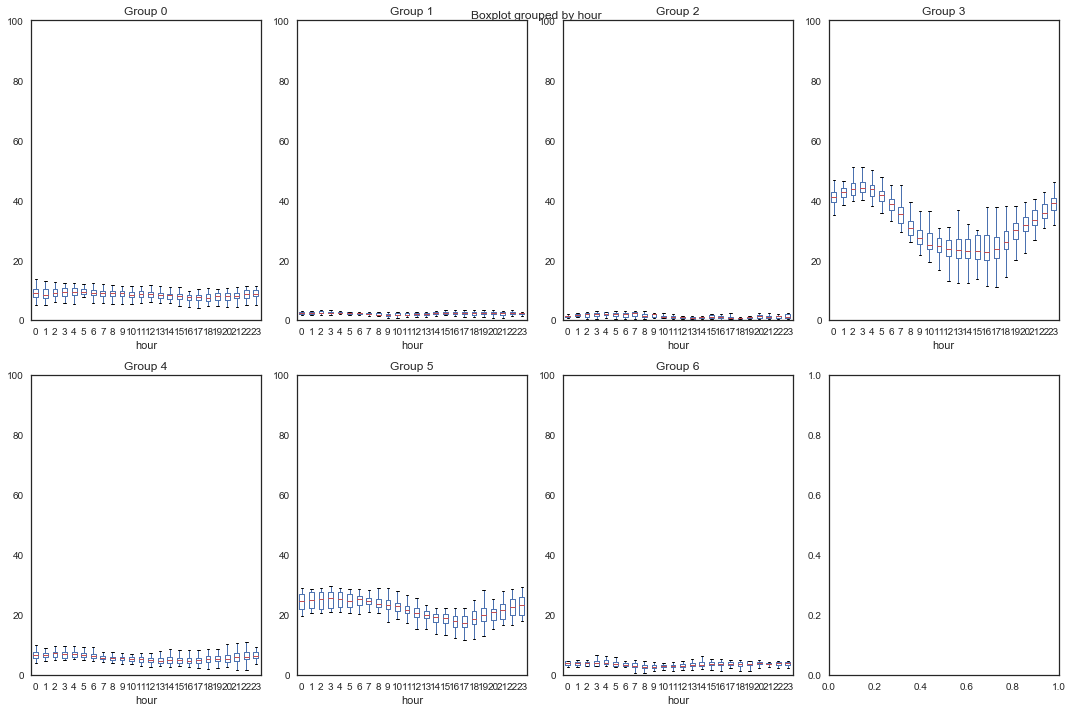

In [88]:
plot_boxplots(weekends_idle, nrows=2, ncols=4, figsize=(15,10), ylim=100, 
              filepath='../../clusters_data/Images/weekends_boxplots_idle/')

### Duration analysis

Weekdays:

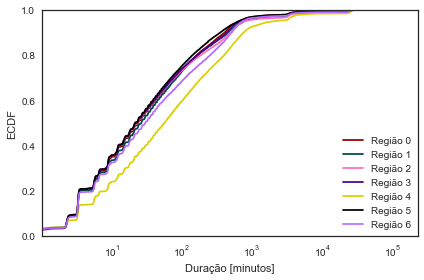

In [89]:
plot_cdf(weekdays_idle, column='duration', xlabel='Duração [minutos]', ylabel='ECDF', xscale='log',
         savefile='../../clusters_data/Images/weekdays_duration_idle.pdf')

Weekends:

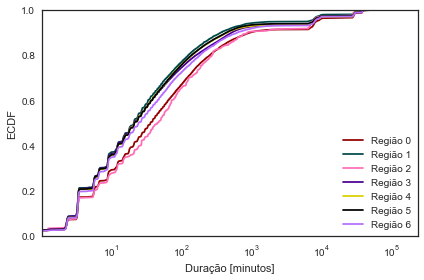

In [90]:
plot_cdf(weekends_idle, column='duration', xlabel='Duração [minutos]', ylabel='ECDF', xscale='log',
         savefile='../../clusters_data/Images/weekends_duration_idle.pdf')

### Fontes

* clusterização de viagens de bike in ny: https://chih-ling-hsu.github.io/2018/01/02/clustering-python
* clusterização basica de coordenadas: https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs
* aplicação do metodo elbow: https://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/D3.%20K-Means%20Clustering%20Analysis.ipynb